# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

In [117]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

In [118]:
# Model

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25,
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))

    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt

    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [119]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=pred_prey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes


#### 1. Sensitivity analysis
Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment

In [120]:
#Using Latin Hypercube sampling

nr_experiments = 1000

experiments, outcomes = perform_experiments([py_model],
                                  nr_experiments, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:05<00:00, 179.72it/s]
[MainProcess/INFO] experiments finished


In [121]:
experiments.head(5)

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002219,0.003440,0.058833,0.026419,37850,None,Python
1,0.001619,0.001794,0.060958,0.025619,37851,None,Python
2,0.001557,0.002631,0.056056,0.028387,37852,None,Python
3,0.001542,0.003648,0.041916,0.020916,37853,None,Python
4,0.000635,0.003751,0.046966,0.029379,37854,None,Python


In [122]:
# 1000 experiments, 1461 steps
print(outcomes['prey'].shape)
outcomes['prey']

(1000, 1461)


array([[50.        , 49.77559266, 49.53657293, ..., 24.29405687,
        24.44740698, 24.60168086],
       [50.        , 49.91546338, 49.82816493, ..., 25.37470581,
        25.25789173, 25.14268802],
       [50.        , 49.96564368, 49.92397035, ..., 49.09867477,
        48.83199701, 48.55558369],
       ...,
       [50.        , 49.85739218, 49.70014961, ...,  4.28421923,
         4.28161066,  4.27952696],
       [50.        , 50.21300526, 50.42202591, ..., 57.35210721,
        57.25233731, 57.13322806],
       [50.        , 50.15974552, 50.31979136, ..., 68.2168218 ,
        68.30419734, 68.3892276 ]])

In [132]:
#selecting final values (last value of every experiment)
prey_final_linear = outcomes['prey'][:,-1]
prey_mean_linear = np.mean([outcomes['prey']], axis= 2)
prey_std_linear = np.std([outcomes['prey']], axis= 2)

In [133]:
print(prey_final_linear.shape, prey_mean_linear.shape, prey_std_linear.shape)

(1000,) (1, 1000) (1, 1000)


In [125]:
import pandas as pd
import statsmodels.api as sm

# Y variable is final outcome of prey
Y = prey_final_linear
# X variables is experiment uncertainties
X = pd.DataFrame(experiments).drop(['policy','model'], inplace = False, axis=1)
X = sm.add_constant(X)

est = sm.OLS(Y, X.astype(float)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     134.6
Date:                Sun, 21 May 2023   Prob (F-statistic):          5.33e-109
Time:                        23:10:08   Log-Likelihood:                -4190.3
No. Observations:                1000   AIC:                             8393.
Df Residuals:                     994   BIC:                             8422.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  24.9122    

#### 2. SOBOL
Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.

*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply use slicing to get the results for N=50 and N=250.

In [126]:
problem = get_SALib_problem(uncertainties)
problem

{'num_vars': 4,
 'names': ['predation_rate',
  'predator_efficiency',
  'predator_loss_rate',
  'prey_birth_rate'],
 'bounds': [(0.0005, 0.003), (0.001, 0.004), (0.04, 0.08), (0.015, 0.035)]}

In [173]:
nr_experiments = 1000
exp_sobol, out_sobol = perform_experiments([py_model],
                                  nr_experiments, uncertainty_sampling=Samplers.SOBOL)

#Output Values Sobol
prey_final_sobol = out_sobol['prey'][:,-1]
prey_mean_sobol = np.squeeze(np.mean([out_sobol['prey']], axis= 2))
prey_std_sobol = np.squeeze(np.std([out_sobol['prey']], axis= 2))

c:\Users\ryant\miniconda3\envs\ema\Lib\site-packages\SALib\sample\sobol.py:132: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  base_sequence = qrng.random(N)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|███████████████████████████████████| 10000/10000 [00:47<00:00, 211.58it/s]
[MainProcess/INFO] experiments finished


In [174]:
#prey_final_sobol.shape
#prey_mean_sobol.shape
#prey_std_sobol.shape
Si = sobol.analyze(problem, prey_mean_sobol, print_to_console=True)

                           ST   ST_conf
predation_rate       0.004822  0.001006
predator_efficiency  0.812871  0.061092
predator_loss_rate   0.215472  0.023987
prey_birth_rate      0.011519  0.001279
                           S1   S1_conf
predation_rate       0.002991  0.005887
predator_efficiency  0.781334  0.081934
predator_loss_rate   0.173858  0.036934
prey_birth_rate     -0.004850  0.009130
                                                 S2   S2_conf
(predation_rate, predator_efficiency)     -0.000590  0.013942
(predation_rate, predator_loss_rate)       0.003481  0.009064
(predation_rate, prey_birth_rate)          0.003615  0.008888
(predator_efficiency, predator_loss_rate)  0.043213  0.140599
(predator_efficiency, prey_birth_rate)     0.004166  0.123685
(predator_loss_rate, prey_birth_rate)      0.014241  0.048515


In [175]:
Si_filter_s1_st = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter_s1_st, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
predation_rate,0.004822,0.001006,0.002991,0.005887
predator_efficiency,0.812871,0.061092,0.781334,0.081934
predator_loss_rate,0.215472,0.023987,0.173858,0.036934
prey_birth_rate,0.011519,0.001279,-0.004850,0.009130


##### Sobol Indices
- sobol first order indices (S1): influence of each uncertainty on variances
- sobol total indices: influences of each uncertainty interaction (n-orders) on variances

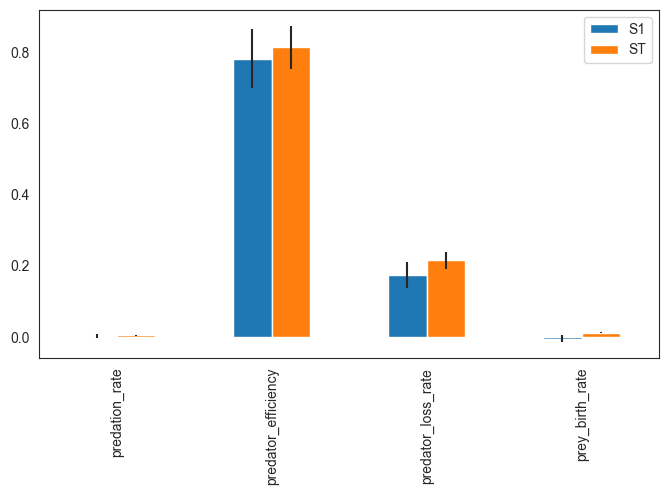

In [176]:
import seaborn as sns

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

##### Sobol Convergence
- Find out how many samples are necessary for convergence

In [177]:
Y = prey_mean_sobol

n_exp = 1000
s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

C:\Users\ryant\AppData\Local\Temp\ipykernel_15456\1281003913.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  s_data.loc[:,j] = scores['ST']


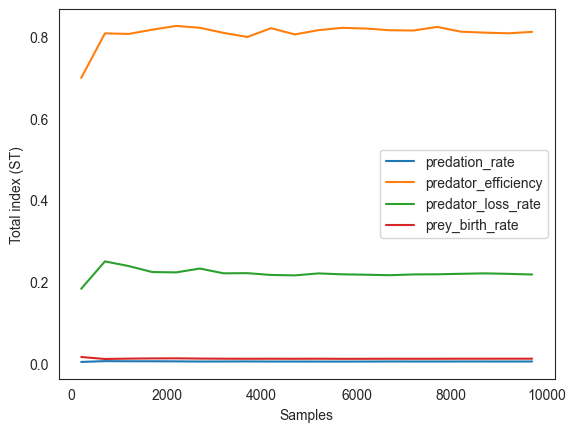

In [178]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

#### 3. Extra trees
Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [ ]:
from ema_workbench.analysis import feature_scoring

#Sobol Sampling
nr_experiments = 1000
exp_sobol, out_sobol = perform_experiments([py_model],
                                  nr_experiments, uncertainty_sampling=Samplers.SOBOL)
#Output Values Sobol
prey_final_sobol = out_sobol['prey'][:,-1]
prey_mean_sobol = np.squeeze(np.mean([out_sobol['prey']], axis= 2))
prey_std_sobol = np.squeeze(np.std([out_sobol['prey']], axis= 2))



##### Feature Scoring
- Feature scoring is a family of techniques often used in machine learning to identify the most relevant features to include in a model. This is similar to one of the use cases for global sensitivity analysis, namely factor prioritisation. 

In [181]:
scores = feature_scoring.get_ex_feature_scores(exp_sobol, prey_final_sobol, max_features=0.6, mode=RuleInductionType.REGRESSION)
scores

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


(                            1
 0                            
 predator_efficiency  0.522027
 predator_loss_rate   0.221235
 prey_birth_rate      0.205254
 predation_rate       0.051485,
 ExtraTreesRegressor(bootstrap=True, max_features=0.6, min_samples_leaf=3,
                     min_weight_fraction_leaf=0, oob_score=True))

In [183]:
combined_scores = []
for j in range(100, exp_sobol.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(exp_sobol.iloc[0:j, :],
                                                   prey_mean_sobol[0:j],
                                                   max_features=0.6,
                                                   mode=RuleInductionType.REGRESSION)[0]
    scores.columns = [j]
    combined_scores.append(scores)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

In [184]:
combined_scores = pd.concat(combined_scores, axis=1, sort=True)
combined_scores

,100,200,300,400,500,600,700,800,900,1000,...,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900
0,,,,,,,,,,,,,,,,,,,,,
predation_rate,0.049438,0.039167,0.039330,0.034043,0.035316,0.039211,0.034040,0.029027,0.026138,0.025440,...,0.006897,0.007243,0.007394,0.007464,0.007135,0.006966,0.007503,0.007497,0.006931,0.007020
predator_efficiency,0.594151,0.714140,0.690574,0.716902,0.724636,0.725832,0.732810,0.745018,0.748518,0.747788,...,0.786606,0.786334,0.785315,0.786698,0.786030,0.788019,0.784307,0.787163,0.788478,0.786084
predator_loss_rate,0.314152,0.196968,0.219507,0.207789,0.206936,0.202868,0.204656,0.198132,0.199172,0.199729,...,0.197873,0.197227,0.197927,0.196748,0.197405,0.195925,0.198384,0.195999,0.195383,0.197555
prey_birth_rate,0.042259,0.049726,0.050589,0.041266,0.033111,0.032089,0.028494,0.027824,0.026172,0.027042,...,0.008624,0.009197,0.009364,0.009091,0.009429,0.009090,0.009806,0.009340,0.009208,0.009342


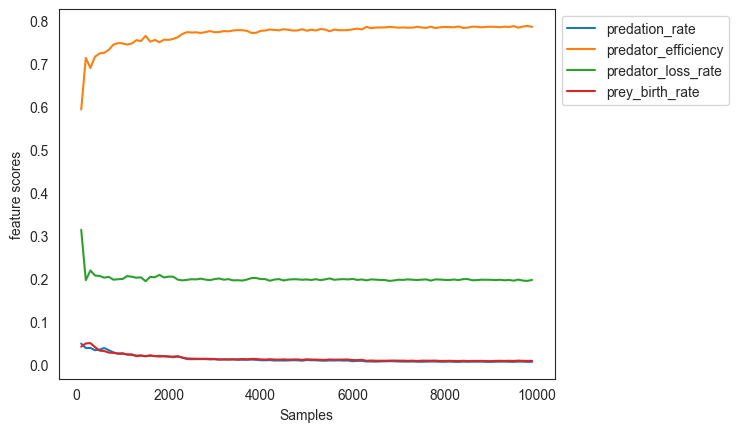

In [185]:
fig, ax = plt.subplots(1)

combined_scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()